# Otto Group Product Classification

Este notebook é uma proposta de solução
utilizando técnicas de data-mining e machine learn para o problema de
classificação de produtos da companhia Otto disponíveis em: [Kaggle (challenge):
Otto group product classification](https://www.kaggle.com/c/otto-group-product-
classification-challenge)

## Contexto

Retirado da descrição do problema, temos
que o grupo Otto é uma das maiores companhias de *e-commerce* do mundo, e possui
s filiais em mais de 20 paises. Vendem milhões de produtos ao redor do mundo
todos os dias com centezas de produtos sendo adicionados constantemente.

A
análise de consistência da performance dos produtos deles é crucial, entretando,
com a infraestrutura de escala global que possuem, produtos identicos são
classifidados de maneira diferenciada. Entretanto a análise da qualidade dos
produtos depende fortemente da acurácia na habilidade de agrupar produtos
semelhantes. Quanto melhor for a classificação, mais intuitivamente eles ter um
maior alcance com seus produtos.

## Dados

Foram disponibilizados 2 bases de
dados separadas. A primeira delas contém 61878 registros com rótulo da
classificação do produto e 144368 de registros sem o rótulo.

São um total de 93
características na qual não há a descrição do que significa cada uma delas.
Sendo que não há dados faltando. O range dos dados vão de 0 a 352.

In [1]:
# Configure to show multiples outputs from a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import math

In [2]:
with zipfile.ZipFile('Datasets.zip') as ziped_file:
    with ziped_file.open('Datasets/train.csv') as train_file:
        df_train = pd.read_csv(train_file, header=0).set_index('id')
    with ziped_file.open('Datasets/test.csv') as test_file:
        df_test = pd.read_csv(test_file, header=0).set_index('id')
df_target = pd.DataFrame(df_train.pop('target')) # Get the target
df_target.target = pd.Categorical(df_target.target) # Transform target in Categorical type
df_target['categories'] = df_target.target.cat.codes # Add the codes in a columns
df_target.head() # Show target classes
df_train.head() # The train dataset
df_test.head() # It hasn't target

,target,categories
id,,
1,Class_1,0
2,Class_1,0
3,Class_1,0
4,Class_1,0
5,Class_1,0


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,6,1,5,0,0,1,...,22,0,1,2,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,3,...,0,0,11,1,20,0,0,0,0,0
2,2,2,14,16,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
3,0,1,12,1,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
5,1,0,0,1,0,0,1,2,0,3,...,0,0,0,0,0,0,0,9,0,0


# Benchmark

A variável results é um acumulador para salvar os resultados na
base de treino e teste de cada um dos modelos e compará-los ao final.

Segue a
estrutura:

`
 'modelo':
     'teste': value
     'treino': value
`

In [3]:
from sklearn.model_selection import train_test_split

results = {}
def add_results(model, train, test):
    results[model] = {
        'train': train*100,
        'test': test*100,
    }

# Cross Validation

A abordagem para a Validação Cruzada é a utilização do
método de k-partições. Neste método, o conjunto de dados é dividido em k
partições [(WITTEN e FRANK,
2000)](ftp://ftp.ingv.it/pub/manuela.sbarra/Data%20Mining%20Practical%20Machine%20Learning%20Tools%20and%20Techniques%20-%20WEKA.pdf),
testes extensivos em diversas bases de dados, utilizando diversos algoritmos,
identificaram o valor de k para identificar a melhor margem de erro como sendo
10, também de forma randômica. Então, o conjunto de dados de treinamento é
criado com k – 1 partições, e apenas uma partição é utilizada para testes. São
realizadas k iterações, aonde cada partição é utilizada uma vez para testes
enquanto as outras são utilizadas para treinamento. Após todas as partições
terem sido utilizadas para teste, a margem de erro de cada iteração é somada e a
média das k iterações se torna a margem de erro do modelo.

![cross
val](crossval.png)
<center>Representação do método Cross Validation com k = 10.
**Fonte**: BABATUNDE et al., 2015.</center>

# Tratamento

Será realizada as
etapas de feature selection e feature
engineering.
Correlação entre features
Será realizada uma análise da correlação
entre as features. Visto que há um
total de 93 colunas que não foi
disponibilizada nenhuma informação sobre o que
são elas e o que representam e
portanto, esta análize ajudará a identificar as
relações entre as features.

## Correlação

A correlação entre duas variáveis é
quando existe algum laço
matemático que envolve o valor de duas variáveis de
alguma forma [ESTATÍSTICA II
- [CORRELAÇÃO E
REGRESSÃO](http://www.ctec.ufal.br/professor/mgn/05CorrelacaoERegressao.pdf).
Uma das maneiras mais simples de se identificar a correlação entre duas
variáveis é plotando-as em um gráfico, para tentar identificar alguma relação
entre elas, entretanto, como são um total de 93 features, dificulta visualizar a
correlação em forma gráfica.

A correlação de
[Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de%0A_Pearson)
mede o grau da correlação (e a direcção dessa correlação - se
positiva ou
negativa) entre duas variáveis de escala métrica (intervalar ou de
rácio/razão).
Já a correlação de
[Spearman](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_postos_de_Spearman)
entre duas variáveis é igual à correlação de Pearson entre
os valores de postos
daquelas duas variáveis. Enquanto a correlação de Pearson
avalia relações
lineares, a correlação de Spearman avalia relações monótonas,
sejam elas
lineares ou não.

Visto ambos os tipos de correlação, utilizaremos a
de Pearson
para avaliar se há alguma correlação linear crescente ou decrescente
entre as
variáveis, pois esta relação nos possibilita remover uma delas sem
prejuizos aos
modelos de machine learn

In [4]:
shape = (df_train.shape[1], df_train.shape[1])
upper_matrix = np.tril(np.ones(shape)).astype(np.bool)
np.fill_diagonal(upper_matrix, False)
correlation = df_train.corr('pearson').abs().where(upper_matrix)
correlation

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
feat_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_2,0.031332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_3,0.027807,0.082573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_4,0.027529,0.134987,0.583523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_5,0.042973,0.020926,0.010880,1.729026e-02,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_6,0.043603,0.041343,0.004288,1.405895e-02,0.145355,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_7,0.298952,0.222386,0.001294,1.448981e-02,0.075047,0.088014,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_8,0.056321,0.019815,0.053462,4.618407e-02,0.035861,0.012867,0.038121,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_9,0.032285,0.025630,0.063551,4.624977e-02,0.024708,0.009373,0.027146,0.039281,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feat_10,0.097776,0.051925,0.036944,5.951396e-02,0.091324,0.041940,0.194258,0.000023,0.024323,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Filtrando colunas

A partir da matriz de correlação assima, buscamos agora
identificar quais das colunas possuem uma forte correlação de acordo com a
tabela a seguir.
Como sugerido por
[Makuka,2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/)
<center>Interpretação do resultado de correlação </center>

|Valor
absoluto|Significado|
|---|---|
|0.9 < v | Muito forte |
|0.7 < v <= 0.9 | Forte
|
|0.5 < v <= 0.7 | Moderada |
|0.3 < v <= 0.5 | Fraca |
|0.0 < v <= 0.3 |
Desprezível |

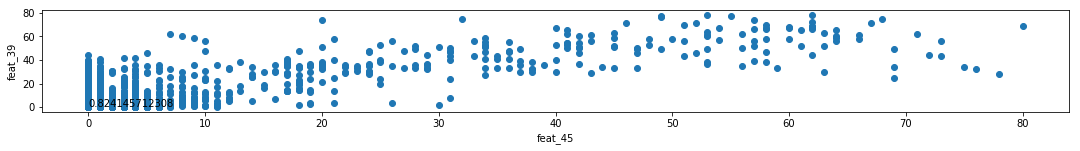

In [5]:
strong_correlation = correlation.where(correlation > 0.8)
strong_correlation = strong_correlation.dropna(how='all', axis=(0,1))
corr_features = strong_correlation[strong_correlation.notnull()].stack().index
corr_features_size = len(corr_features)
if corr_features_size:
    col = math.floor(math.log2(corr_features_size)) or 1
    row = math.ceil(corr_features_size/col)
    figure, axis = plt.subplots(row, col, figsize=[15,2*row])
    figure.tight_layout()
    for idx, (feature1, feature2) in enumerate(corr_features):
        if row == 1: # Has a single element
            plot = axis.scatter(df_train[feature1],df_train[feature2])
            plot = axis.set_xlabel(feature1)
            plot = axis.set_ylabel(feature2)
            plot = axis.annotate(strong_correlation[feature2][feature1],xy=(0,0))
        elif col == 1: # Has multiples elements, but is a array
            plot = axis[idx].scatter(df_train[feature1], df_train[feature2])
            plot = axis[idx].set_xlabel(feature1)
            plot = axis[idx].set_ylabel(feature2)
            plot = axis[idx].annotate(strong_correlation[feature2][feature1],xy=(0,0))
        else: # Multitle elements and is a matrix
            plot = axis[int(idx/col), idx%col].scatter(df_train[feature1], df_train[feature2])
            plot = axis[int(idx/col), idx%col].set_xlabel(feature1)
            plot = axis[int(idx/col), idx%col].set_ylabel(feature2)
            plot = axis[int(idx/col), idx%col].annotate(strong_correlation[feature2][feature1],xy=(0,0))
    plt.show()

## Resultado

A correlação mostra que não há uma fortíssima correlação entre as
features, entretanto, há 10 colunas que estão fortemente correlacionadas. Porem
buscamos uma correlação fortíssima para não remover features com comportamentos
diferentes.

# Train/Test split

Utilizaremos 80% da base de treino para
efetivamente treinar o modelo e 20% para
averiguar a performance do modelo.

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

X = df_train
y = df_target.categories
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Feature Scaling

Trata-se do processo de transformar todos os dados da
amostra para uma unidade padrão, neste problema utilizaremos a técnica de
padronização que consiste em remover a média dos dados e colocar todos na escala
do desvio padrão [Wikipedia](https://en.wikipedia.org/wiki/Feature_scaling). Em
que $\bar{x}$ é a média e $\sigma$ é o desvio padrão.

\begin{equation}
    x' =
\frac{x - \bar{x}}{\sigma}
\end{equation}

In [7]:
sc_X = StandardScaler()
sc_X_train = sc_X.fit_transform(X_train)
sc_X_test = sc_X.transform(X_test)

Feature scaling foi aplicado nos dataframes de **features** e utilizado nos
modelos, mas o resultado não apresentou mudança. Os modelos continuaram com
exatamente as mesmas performances.

### Confusion Matrix

A matriz de confução é
uma métrica para algorítmos supervisionados em que é possível estabelecer uma
relação entre os acertos e erros durante a classificação do conjunto de
amostras. Basicamente elabora-se uma matriz em que nas colunas e linhas são as
possíveis classes. Cada célula traz a contagem de amostras que eram da Label X
(coluna) e foram classificadas na Label Y (linha). Dessa forma, na matriz, a
diagonal principal trará os acertos do classificador
[Microsoft](https://docs.microsoft.com/pt-br/sql/analysis-services/data-
mining/classification-matrix-analysis-services-data-mining). Veja o exemplo a
seguir:

|Classificador\Real|Label 1|Label 2|Label 3|
|---|-------|-------|-------|
|**Label 1**|10|10|0|
|**Label 2**|1|10|1|
|**Label 3**|0|0|3|

Plot para matriz de confusão encontrado em
[Scikit](http://scikit-
learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-
glr-auto-examples-model-selection-plot-confusion-matrix-py) e adaptado para o
problema

In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(11, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Modelo Dummy Classifier

Dummy Classifier é um modelo que faz predições
usando regras simples.

O dummy é importante para termos como parâmetro de
comparação com outros modelos.Não pode ser utilizado em problemas reais porque
ele é apenas para realizar comparações e trabalha com aleatoriedade e frequencia
de repetições para realizar as predições.

Usamos dois tipos de estratégia:

* **Stratified**: realiza predições baseadas na
distribuição das classes da base
de treino. (Ex.: 10% A, 20% B, 50% C, 20% D)   
* **Most Frequent**: sempre prediz
com a classe mais frequente na base de treino

Confusion matrix, without normalization


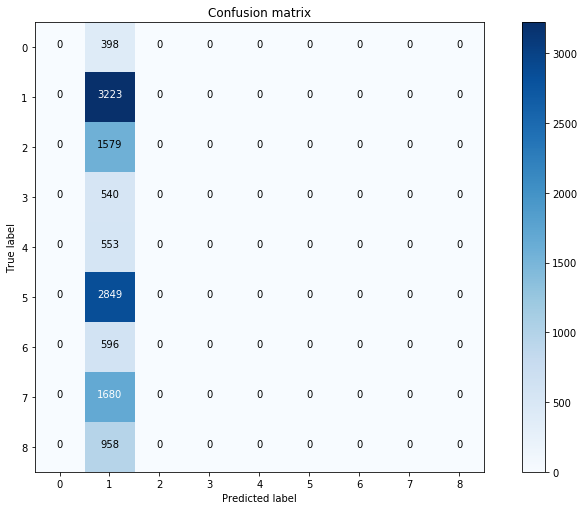

most_frequent train dataset score: 0.26
Média: 0.26
Desvio padrão: 0.0001
Confusion matrix, without normalization


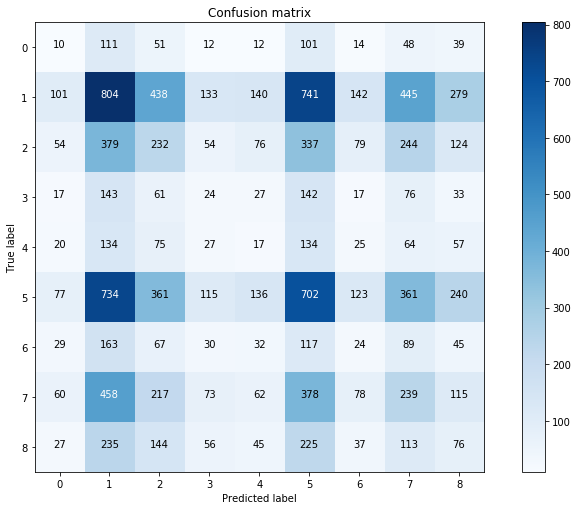

stratified train dataset score: 0.17
Média: 0.17
Desvio padrão: 0.0054


In [9]:
from sklearn.dummy import DummyClassifier

def dummies(X_train, y_train, X_test, y_test):
    models = ['most_frequent', 'stratified']

    for model in models:
        clf = DummyClassifier(strategy=model)
        clf.fit(X_train, y_train)
        score = clf.score(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        plot_confusion_matrix(cm, classes=model)
        # Cross validation
        accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)
        
        add_results(model, clf.score(X_train, y_train), clf.score(X_test, y_test))
        print(model, 'train dataset score: %.2f' % score)
        print('Média: %.2f' % accuracies.mean())
        print('Desvio padrão: %.4f' % accuracies.std())

dummies(X_train, y_train, X_test, y_test)

## Boosting

A definição de boosting é que até mesmo algorítmos
fracos de
machine larning podem se tornar potentes [(KEARNS,
1988)](https://www.cis.upenn.edu/~mkearns/papers/boostnote.pdf).

Um algorítmo
fraco de aprendizagem pode ser definido como modelos ou regras que não possuem
boa acurácia ou aparentam ser ineficientes, tais como modelos *dummy*: mais
frequente, estratificado, randômico. Já algorítmos de aprendizagem forte, são
aqueles que apresentam uma boa taxa de acertos [(FREUND e
SCHAPIRE)](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=4BF3325D8222B3234BB95971FCAD8759?doi=10.1.1.56.9855&rep=rep1&type=pdf).
**Exemplo - Corrida de cavalos**[(FREUND e
SCHAPIRE)](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=4BF3325D8222B3234BB95971FCAD8759?doi=10.1.1.56.9855&rep=rep1&type=pdf):
Como determinar em qual cavalor apostar, considerando um conjunto de dados
disponíveis tais como informações do cavalo, do dono, das corridas anteriores e
etc. Ao perguntar para especialistas cada um deles irá falar coisas distintas e
ainda assim muito imprecisas (modelos fracos)! Mas seria possível utilizar as
regras de aposta de cada especialista e gerar uma única regra que seja capaz de
predizer o cavalor vencedor da corrida utilizando boost 
    
## Gradient
Descent

![](http://matthewemery.ca/images/gradient_descent.gif)

Um algorítmo
de gradient descendent é uma forma de minimizar o valor de uma função
interativamente, na qual são dados um conjunto de parametros e ela busca a
partir daí o menor valor[(TOUSSAINT, 2012)](https://ipvs.informatik.uni-
stuttgart.de/mlr/marc/notes/gradientDescent.pdf). De forma que:
\begin{equation}
y_{min} = F(x_1) > F(x_2) > F(x_3) > ... > F(x_n),\ onde:\
F(x_n) < precisão
\end{equation}

Um pseudo algorítmo que pode ser proposto para
um problema de
gradient é:

#  XGBoost

XGBoost é um algoritmo que implementa
*gradient boosting* de
Decision Trees de
forma rápida e com alta performance.
**Gradient Boosting** é
uma técnica de *machine learning* para problemas de
regressão e classificação
que produz um modelo de predição na forma de
*ensemble* de modelos de predições
fracas, normalmente árvores de decisões.
Boosting é um processo sequencial, mas
como o `XGBoost` consegue implementá-lo
de forma paralela?
Sabemos que cada
árvore pode ser produzida apenas depois que
produzida a árvore anterior, mas o
processo de criar as árvores pode ser
paralelizado utilizando todos os núcleos a
disposição.

## Model
### Objective Function:
\begin{equation}
\text{obj}(\theta) = L(\theta)
+ \Omega(\theta)
\end{equation}

**L- Training Loss function**: Mede predição do
modelo na base de treino. (Métrica: *Mean Squared Error*(MSE))   
**Omega-
Regularization function **: Controla a complexidade do modelo (Ajuda a evitar o
*Overfitting*)

nota: As *objective functions* devem sempre possuir *training
loss* e *regularization* 

![](https://raw.githubusercontent.com/dmlc/web-
data/master/xgboost/model/step_fit.png)

### CART
Uso de *CARTs* (Classification
And Regression Trees) no ensemble das árvores
![](https://raw.githubusercontent.com/dmlc/web-
data/master/xgboost/model/twocart.png)


Modelo de ensemble de árvores IGUAL ao
modelo Random Forest, mas onde está então a diferença?

## Training
### Additive
Training:

Precisamos agora melhorar os paramêtros da função de
**Regularization**, mas como fazer isso? Fazer isso aqui é muito mais difícil do
que em problemas de otimização tradicionais, onde você pode usar o gradiente
para isso. Não é fácil treinar todas as árvores ao mesmo tempo. Em vez disso,
usamos uma **estratégia aditiva**: consertamos o que aprendemos e adicionamos
uma nova árvore de cada vez.


\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &=
f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &=
\sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{split}

In [ ]:
x = inital_value
step = 0.01

repita
xprev=x
        x = xperv - step * F(xprev)
    enquanto abs(x - xprev)
>
precisao

/home/gabrielziegler/PyEnv/MachineLearning/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBoost fit
XGBoost train score
XGBoost test score
XGBoost confusion matrix
XGBoost cross validation
XGBoost results
Confusion matrix, without normalization


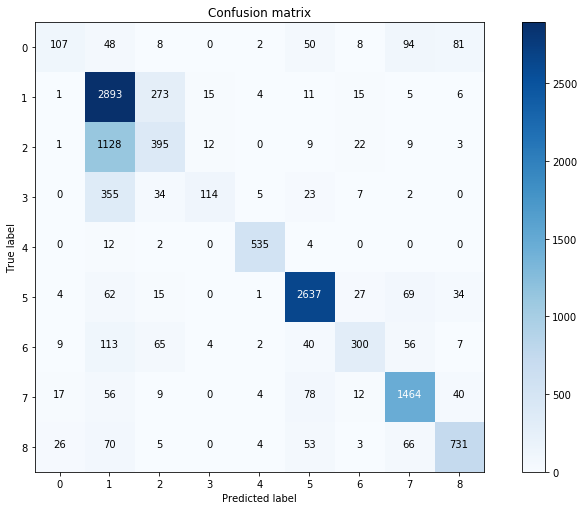

Resultado na base de treino 0.75
Resultado Médio na base de teste: 0.74
Desvio padrão: 0.0030
CPU times: user 1h 2min 3s, sys: 3.43 s, total: 1h 2min 6s
Wall time: 8min 13s


In [11]:
%%time
from xgboost import XGBClassifier

def xgboost(X_train, y_train, X_test, y_test):    
    xgbclf = XGBClassifier(
        learning_rate=0.01,
        n_estimators=140,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=8,
        scale_pos_weight=1
        )
    print('XGBoost fit')
    xgbclf.fit(X_train, y_train)
    print('XGBoost train score')
    train_score = xgbclf.score(X_train, y_train)
    print('XGBoost test score')
    y_pred = xgbclf.predict(X_test)

    print('XGBoost confusion matrix')
    cm = confusion_matrix(y_test, y_pred)

    print('XGBoost cross validation')
    accuracies = cross_val_score(estimator=xgbclf, X=X_train, y=y_train, cv=10)
    
    print('XGBoost results')
    add_results('xgboost', xgbclf.score(X_train, y_train), xgbclf.score(X_test, y_test))
    
    plot_confusion_matrix(cm, classes=xgbclf)
    print('Resultado na base de treino %.2f' % train_score)
    print('Resultado Médio na base de teste: %.2f' % accuracies.mean())
    print('Desvio padrão: %.4f' % accuracies.std())
    

xgboost(X_train, y_train, X_test, y_test)

## GridSearchCV
A ferramenta GridSearch disponibilizada pelo Scikit, gera de
forma exaustiva candidatos a partir de um grid de  parâmetros especificados com
o atributo param_grid.

In [12]:
dt_params = [{
    'max_depth': [40, 50, 60, 80, 100, 120],
    'max_features': [70, 80, 90, 92],
    'min_samples_leaf': [2, 5, 10, 20, 30, 40]
}]

xgb_params = [{
    'max_depth': [4, 5, 6],
    'min_child_weight': [4, 5, 6]
}]

In [13]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def search_params(classifier, params):
    clf = classifier()
    grid_search = GridSearchCV(estimator=clf,
                               param_grid=params,
                               cv = 4,
                               n_jobs=-1)

    grid_search = grid_search.fit(X_train, y_train)
    print(grid_search.best_score_, grid_search.best_params_)
    return grid_search.best_score_

CPU times: user 0 ns, sys: 16 ms, total: 16 ms
Wall time: 508 ms


### Aplicando GridSearchCV ao XGBClassifier:

In [ ]:
%%time
from xgboost import XGBClassifier

# Takes long time to run
search_params(XGBClassifier, xgb_params)

Aplicando GridSearchCV ao Decision Tree Classifier:

In [15]:
search_params(DecisionTreeClassifier, dt_params)

0.716051876692 {'max_features': 80, 'min_samples_leaf': 10, 'max_depth': 50}


0.71605187669185089

## Decision Tree

Os dados são separados recursivamente formando uma árvore de
decisão baseada nas
features.Pode-se definir uma árvore de decisão, conforme diz
(MITCHELL, 1997),
como um método para aproximar valores discretos em funções,
onde a função de
aprendizagem é representada por uma árvore de decisão. Tais
árvores aprendidas
podem ser representadas - a nível de código fonte - como
conjuntos de estruturas
condicionais "se-então" para melhorar a leitura e
entendimento humano, de acordo
com (MITCHELL, 1997).

Estes algoritmos são muito
utilizados, segundo (MITCHELL, 1997), na área de
algoritmos de inferência
indutiva, e dentre as aplicações de tais algoritmos,
tem-se máquinas que
aprenderam a diagnosticar casos da medicina, ou ainda, para
avaliar o risco de
inadimplência dos requerentes de créditos em bancos.

Para visualizar de forma
mais fácil a representação de uma árvore, a figura 3,
representada abaixo,
caracteriza uma árvore de decisão em que a máquina deve
decidir com base nas
variáveis do tempo (ensolarado, nublado ou chuvoso), se
pode ou não ocorrer uma
partida de tênis. Além das variáveis de tempo, tem-se
outras variáveis que podem
ser levadas em conta dependendo da condição climática local, como umidade (alta
ou normal) e o vento (forte ou fraco).

![Workflow Random
forest](arvore_jogo_tenis.png)

O algoritmo de árvores de decisão classifica
instâncias ou dados, ordenando-os
apartir da raiz da árvore, para os nós de suas
folhas. Cada nó da árvore
exemplifica uma pergunta (teste) de alguns - atributos
- de instância, e cada
ramo descendente de um nó corresponde para um dos
possíveis valores de tal
atributo (MITCHELL, 1997). Vale a pena citar: O
algoritmo ID3 (QUINLAN, 1986)
aprende sobre árvores de decisão construindo-as de
cima para baixo (nó raiz para
as ramificações) tentando buscar respostas para a
pergunta "Qual atributo
devemos testar na raiz da árvore?", sendo assim, cada
atributo instanciado é
calculado por meio de testes estatísticos, para
determinar o quão bem (ótimo)
tal atributo, isolado dos demais, classifica os
exemplos de treinamento.

Quando o melhor atributo é selecionado e utilizado
como teste no nó principal da
árvore, cria-se um descendente para cada valor
admissível deste atributo e os
exemplos de treinamento são sorteados para o nó
filho mais apropriado. O
processo inteiro é então repetido utilizando
treinamentos associados a cada
descendente para selecionar o melhor atributo
para testar na árvore. Quando
realizado dessa forma, o algoritmo tenta de forma
“gulosa“3.4. O modelo 49
Figura 3 – Exemplo de árvore de decisão, sobre
condições para realização de um
jogo de
tênis.

In [16]:
from sklearn.model_selection import cross_val_score

def fit_tree(X_train, y_train, X_test, y_test, tree_description='decision_tree'):
    tree_clf = DecisionTreeClassifier(max_features=70, min_samples_leaf=10, max_depth=40)
    tree_clf.fit(X_train, y_train)

    inner_score = tree_clf.score(X_train, y_train)
    tree_fit = cross_val_score(tree_clf, X_train, y_train)
    
    add_results(tree_description, tree_clf.score(X_train, y_train), tree_clf.score(X_test, y_test))
    
    return inner_score, tree_fit.mean(), tree_fit.std()

"inner: {:.2f} cross: {:.2f} +/- {:.2f}".format(*fit_tree(X_train, y_train, X_test, y_test))

'inner: 0.80 cross: 0.71 +/- 0.00'

## Distribuição dos dados

Um dos modelos a ser utilizado será o decision tree
no método de montagem random forest. Este modelo de predição possui um problema
de viés quando uma das classes na base de treino é mais predominante do que
outra, ou seja, a distribuição das classes na base de treino devem ser
semelhantes para evitar problemas de
[overfiting](http://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-
underfitting-vs-overfitting.html).

Para tanto, precisa-se descobrir qual a
contagem de cada classe disponível na base de treino, montaremos um histograma
para verificar a diferença entre elas.

In [17]:
counts = [0] *len(df_target.target.cat.categories)

def reduce(target):
    counts[target.categories] += 1
    return counts[target.categories]

df_target['increase_count'] = df_target.apply(reduce, axis=1)
df_target.groupby('target').count()
df_target.groupby('target')['increase_count'].max().sum() == df_target.target.count()

,categories,increase_count
target,,
Class_1,1929,1929
Class_2,16122,16122
Class_3,8004,8004
Class_4,2691,2691
Class_5,2739,2739
Class_6,14135,14135
Class_7,2839,2839
Class_8,8464,8464
Class_9,4955,4955


True

### Filtrar dados

Agora, iremos filtrar os dados deixando apenas os primeiros
registros. O critério de filtrar os dados será pegar a classe que possue o menor
número e utilizar ele como base para remover os demais, considerando um tamanho
máximo de até 2x o da menor classe

In [18]:
distance_percent = 2
minimum_value = df_target.groupby('target')['increase_count'].max().min()
df_rtarget = df_target[ df_target.increase_count < minimum_value*distance_percent ]
df_rtarget.groupby('target').count()
df_rtrain = df_train.drop( df_target[df_target.increase_count >= minimum_value * distance_percent].index )
df_rtrain.shape[0] == df_rtarget.shape[0]

,categories,increase_count
target,,
Class_1,1929,1929
Class_2,3857,3857
Class_3,3857,3857
Class_4,2691,2691
Class_5,2739,2739
Class_6,3857,3857
Class_7,2839,2839
Class_8,3857,3857
Class_9,3857,3857


True

### Verificando resultado

Após aplicar uma melhor distribuição nos dados,
rodou-se novamene o algorítmo da decision tree e percebeu-se que a acurácia do
modelo diminuiu, e portanto, não será utilizado.

In [19]:
X_tr, X_te, y_tr, y_te = train_test_split(df_rtrain, df_rtarget.target, test_size=0.2)
"inner: {:.2f} cross: {:.2f} +/- {:.2f}".format(*fit_tree(X_tr, y_tr, X_te, y_te))

'inner: 0.77 cross: 0.65 +/- 0.01'

# Random Forest

Breiman breiman, 2001, descreve Random Forests como uma
evolução das decisions
trees, onde várias ávores são formadas para criar um
modelo com maior precisão.
Isto é feito a partir da separação dos Dados em
conjutos
de dados menores e aleatórios. Cada árvore é contruida a partir de um
pedaço
aleatório dos dados. Quando um novo dado chega, a predição é feita por
todas as
Árvores e ao fim é feita uma
votação por maioria, ou seja, a categoria
com mais votos ganha e o resultado é
dado.

![Workflow Randomforest](forest.jpg)
De acordo com breiman, 2001, as RFs corrigem a maior parte
dos problemas de
Overfitting que as Árvores de decisão apresentam. Tudo depende
do quanto as DT
contidas dentro da Random Forest. Isto é, o quanto elas
representam os dados.
## Utilizando o algoritmo

In [29]:
### %%time

from sklearn.ensemble import RandomForestClassifier

def test_random(params, X_train, y_train, X_test, y_test, name='random_forest'):
    global rfscores
    global rfclf
    rfclf = RandomForestClassifier(**params)
    rfclf = rfclf.fit(X_train, y_train)
    
    train_score = rfclf.score(X_train, y_train)
    test_score = rfclf.score(X_test, y_test)
    rfscores = cross_val_score(rfclf, X_train, y_train)
    add_results(name, train_score, test_score)
    return name, train_score, test_score
params = {'n_estimators': 10, 'max_features': 70, 'min_samples_leaf': 10, 'max_depth': 40}
test_random({}, X_train, y_train, X_test, y_test)
test_random(params, X_train, y_train, X_test, y_test, 'random_forest_otimized')

('random_forest', 0.99274776776695894, 0.78466386554621848)

('random_forest_otimized', 0.83974384873338448, 0.7773917259211377)

## Verificando com Cross Validation

Cross validation irá predizer um pedaço do
dataset utilizando o modelo treinado
com o resto dos dados que não fazem parte
deste dataset.

In [30]:
print ("{} de precisão".format(rfscores.mean() * 100))

75.98276482804197 de precisão


## Importancia das features para a RF

A seguir vemos quais as influências de
cada uma das features para o uso no random forest. Quanto maior no gráfico,
maior é a importância da feature.

### Gini

O método utilizado para gerar a
importância das features no modelo é a Decrease Mean Importance, que utiliza em
seus cálculos um indicador de impureza no sistema. No caso do random forest
implementado [(LOUPPE et
al.,2013)](https://pdfs.semanticscholar.org/2635/19c5a43fbf981da5ba873062219c50fdf56d.pdf),
este indicador é o Gini Impurity que pode ser entendido como uma redução da
probabilidade de errar a classificação de uma categoria dentro de um algorítmo
de árvore [(Sebastian Raschaka)](https://sebastianraschka.com/faq/docs/decision-
tree-binary.html).

#### O indice
O indice de Gini pode ser calculado utilizando
a seguinte
fórmula[(TEKIMONO,2009)](http://people.revoledu.com/kardi/tutorial/DecisionTree/how-
to-measure-impurity.htm):

\begin{equation}
    Gini = 1- \sum_{i=1} p_i^2
\end{equation}
Em que $p_i$ é a probabilidade da ocorrência de uma determinada
classe,
desconsiderando os atributos. Ou seja $N_i$ é o número de ocorrências da
classe
i e N é o total de elementos das classes:

\begin{equation}
    p_i =
\frac{N_i}{N}
\end{equation}

#### Para Decisions Trees

Para Classification and
Regression Trees (CART), utiliza-se o indice de Gini modificado, isto é,
calcula-se ainda as probabilidades em $p_i$, mas agora utiliza-se do indice de
Gini nos filhos da esquerda $t_l$ e direita $t_r$. Recalcula-se as
probabilidades para ambos os nós também em $p_l$ e $p_r$ utilizando como base as
possíveis classes reduzidas a $N_t$ [(LOUPPE et
al.,2013)](https://pdfs.semanticscholar.org/2635/19c5a43fbf981da5ba873062219c50fdf56d.pdf).
\begin{equation}
    i(s, t) = Gini(t) - p_l Gini(t_l) - p_r Gini(t_r) \\
p(t) =
\frac{N_{l|r}}{N_t}
\end{equation}

#### Decrease Mean Importance

Para
calcular
a importância de uma feature X ao tentar predizer uma label Y, utiliza-
se os
indices de impureza com a proporção de $N_f$ amostras em relação ao total
$N$.
$N_T$ é o total de árvores na floresta. Assim, para uma Random Forest a
conta é:
\begin{equation}
    I(X_m) = \frac{1}{N_T} \sum_{T} \sum_{t \epsilon
T:v(s)=X_m} pf(t)i(s,t) \\
    pf(f) = \frac{N_f}{N}
\end{equation}

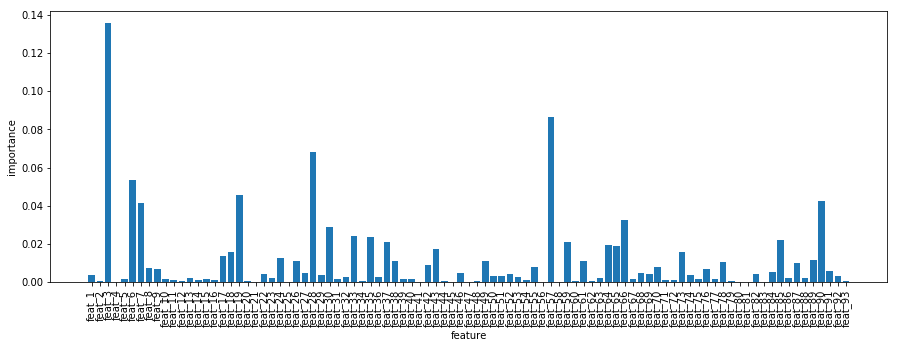

In [32]:
fig, axis = plt.subplots(figsize=(15, 5))
plot = axis.bar(df_train.columns, rfclf.feature_importances_)
plot = axis.set_xticklabels(df_train.columns.values, rotation='vertical')
plot = axis.set_xlabel('feature')
plot = axis.set_ylabel('importance')
plt.show()

## ExtraTrees

O [Scikit Learn](http://scikit-
learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)
nos apresenta um tipo diferente de random forest que pode apresentar resultados
melhores que o [RandomForestClassifier](http://scikit-
learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
Assim como afirma que as extra tree devem ser utilizadas apenas em algorítmos de
montagem Como o Extra Trees Classifier e Regressor.

O que diferencia uma extra
tree de uma decision tree é a forma que é feita a construção da árvore. Enquanto
uma decision tree utiliza cópia dos dados e sub amostras para realizar as
divisões de cada nó. Uma extra tree utiliza um ponto de divisão randomico e
utiliza toda a base de treino para crescer a árvore [(GEURTS, ERNST e WEHENKEL,
2005)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.7485&rep=rep1&type=pdf).

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etscores = cross_val_score(etc, X_train, y_train)
print ("{} de precisão".format((etscores.mean() * 100)))

etc = etc.fit(X_train, y_train)
add_results('extra_trees', etc.score(X_train, y_train), etc.score(X_test, y_test))
print("Inner score", etc.score(X_train, y_train))

76.81707143741309 de precisão
Inner score 1.0


### MLP Classifier
Esse algoritmo é um classificador Perceptron de Multicamadas
usado para fazer o
treinamento de modelos, e é uma biblioteca do Scikit-Learn.

In [24]:
%%time

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
saidas = mlp.predict(X_test)
trac = "---------------------------------------------------"

print(trac)
print('Saida redes neurais: ', saidas)
print('Saida desejada', y_test)
print(trac)
mlpscores = cross_val_score(mlp, X_train, y_train)

print('Score: {} +/- {}'.format(mlpscores.mean(), mlpscores.std()))

add_results('multi_layer_perceptron', mlp.score(X_train, y_train), mlp.score(X_test, y_test))


---------------------------------------------------
Saida redes neurais:  [1 7 3 ..., 1 1 2]
Saida desejada id
5285     1
52122    7
5927     1
19053    2
23237    2
47212    6
20117    2
52409    7
18034    1
33766    5
7062     1
57420    8
47045    6
25969    2
26529    3
20917    2
25919    2
32154    5
23565    2
5004     1
14036    1
2159     1
20789    2
9764     1
25630    2
40226    5
5994     1
37683    5
57932    8
16849    1
        ..
29455    4
9437     1
52517    7
35619    5
41330    5
55999    7
5089     1
16119    1
21132    2
36125    5
47713    6
44805    5
1922     0
39606    5
15718    1
30215    4
3321     1
27351    3
11635    1
10202    1
55232    7
13434    1
52905    7
30884    4
58203    8
21790    2
21011    2
14706    1
12698    1
18336    2
Name: categories, Length: 12376, dtype: int8
---------------------------------------------------
Score: 0.7843123211913164 +/- 0.003915301605727263
CPU times: user 5min 47s, sys: 14min 10s, total: 19min 57s
Wall time: 

# Conclusão

Como conclusão, tivemos a utilização do modelo Random Forest e
Extreme Gradient Boosting otimizados. Mas o gráfico a seguir irá mostrar os
resultados com a base de treino e base de teste.

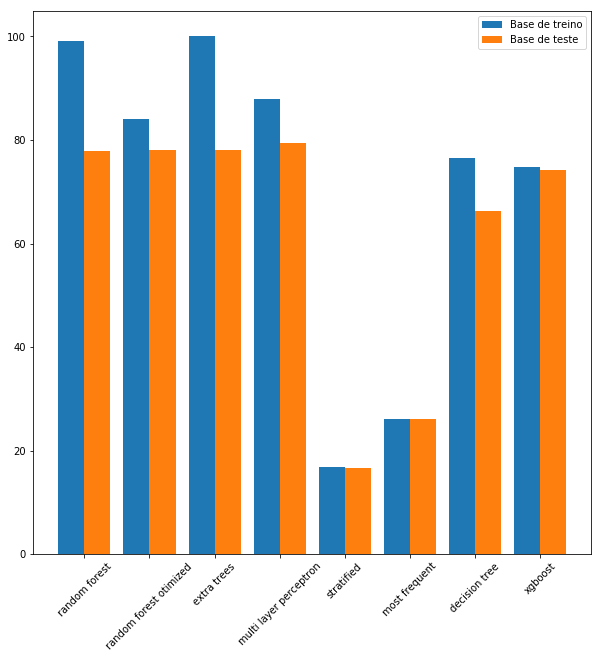

In [25]:
columns = [x.replace('_',' ') for x in results.keys()]
train = []
test = []
width=0.4
base = np.arange(len(columns))
for key in results:
    train.append(results[key]['train'])
    test.append(results[key]['test'])
fig, ax=plt.subplots(figsize=[10,10])
fig = ax.bar(base, train, width)
fig = ax.bar(base+width, test, width)
fig = ax.set_xticks(base+width/2)
fig = ax.set_xticklabels(columns, rotation='45')
fig = ax.legend(['Base de treino', 'Base de teste'])
plt.show()

# Referências Bibliográficas
http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/  
[MITCHELL](https://dl.acm.org/citation.cfm?id=505283), Tom M. Machine learning.
1997. Burr Ridge, IL: McGraw Hill, v. 45, n. 37, p. 870-877, 1997.
[QUINLAN](http://hunch.net/~coms-4771/quinlan.pdf), J.. Ross . Induction of
decision trees. Machine learning, v. 1, n. 1, p. 81-106, 1986.
[BREIMAN](https://www.stat.berkeley.edu/users/breiman/randomforest2001.pdf),
Leo. Random forests. Machine learning, v. 45, n. 1, p. 5-32, 2001.

BABATUNDE,
Oluleye, ARMSTRONG, Leisa, DIEPEVEEN,
Dean e LENG, J. Comparative analysis of
Genetic Algorithm and Particle Swam
Optimization: An application in precision
agriculture. 2015. **Asian Journal of
Computer and Information Systems**. 3.
1-12.